In [3]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '../src'))

In [5]:
from data.data import load_target

In [43]:
# Load Data
target_series = load_target('../data/03_processed/on_forecourt_sessions.csv', group_cols='location_id',
                            time_col='date', value_cols='energy_delivered_kwh', static_cols=['num_evse'], freq='D')[:5]


In [44]:
from features.clustering import stack_timeseries

In [45]:
series = stack_timeseries(target_series)

In [46]:
from darts.models import TFTModel

In [47]:
model = TFTModel(input_chunk_length=64, output_chunk_length=7, add_relative_index=True)
model.fit(series, epochs=1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.7 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 528   
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 1.1 K 
8  | static_cont

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [48]:
predictions = model.predict(n=7, series=series, num_samples=25)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

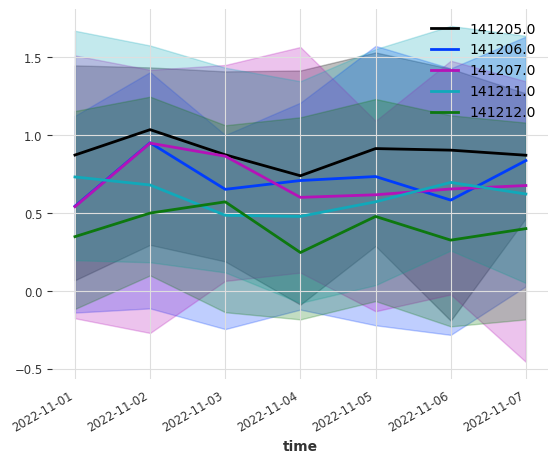

In [49]:
predictions.plot()

In [50]:
from darts.metrics import mse

In [51]:
mse(predictions, predictions)

0.0

In [52]:
single_component = predictions.univariate_component('141205.0')
single_component

<TimeSeries (DataArray) (time: 7, component: 1, sample: 25)>
array([[[ 1.46197844,  0.77509309,  0.40637341,  0.82284422,
          1.26885541,  0.2040782 ,  0.87273982,  1.522119  ,
          1.13258824,  0.89502934,  1.07206224, -0.19790323,
          0.4184284 ,  0.92909104,  0.61159552,  1.3972228 ,
          1.30009314,  0.87899185,  0.28972888,  0.82057314,
          0.85328389,  1.28790119,  1.24055239,  0.81169257,
          0.03388342]],

       [[ 0.2312575 ,  1.23970612,  0.43152222,  1.04572376,
          0.59550274,  0.59455516,  1.43604703,  1.33130202,
          0.26133497,  1.32384579,  1.00586609,  1.4705833 ,
          1.23215243,  1.43280676,  0.67265039,  1.19269799,
          1.36112065,  1.03594365,  1.0094312 ,  1.43614919,
          0.81987812,  1.10421214,  0.63495439,  0.93767507,
          0.50431188]],

       [[ 0.62199081,  1.4006941 ,  0.60918739,  0.29140805,
          0.26318794,  1.2812686 ,  1.38040422,  0.53550582,
          1.37970763,  0.87423796,  1.57248093, -0.27257232,
          1.24926904,  0.87957952,  1.41279086,  0.44804759,
...
          0.28076116,  1.0335973 ,  0.34514779,  0.90566023,
          1.04145286,  0.6595368 ,  0.58767388,  1.30662589,
          1.39021185,  0.63239652,  1.29848972,  1.32574974,
          0.91430101]],

       [[-0.21021793,  1.4461428 ,  1.04842057,  1.39109667,
          1.4105683 ,  1.43141783,  0.54774788,  0.92957311,
          1.0365251 ,  0.84777229,  1.34443393,  0.5428419 ,
          0.89376793,  0.90420176, -0.21123054, -0.11812039,
          1.12986516,  0.43353888,  1.10479392,  0.87845359,
          1.31095864,  0.30242941,  0.22155857,  0.28179102,
          1.2835606 ]],

       [[ 0.87150111,  1.33543485,  1.03956352,  1.21989689,
          0.76240306,  1.15191502,  0.70751697,  0.5529938 ,
          0.87791497,  0.82095296,  0.76239968,  0.70532095,
          0.9352565 ,  0.94071632,  0.51838494,  0.52804685,
          0.85222352,  0.45296803,  0.75939557,  1.26833497,
          0.41461543,  1.07612801,  0.97627464,  1.26929422,
          1.18735398]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-11-01 2022-11-02 ... 2022-11-07
  * component  (component) object '141205.0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

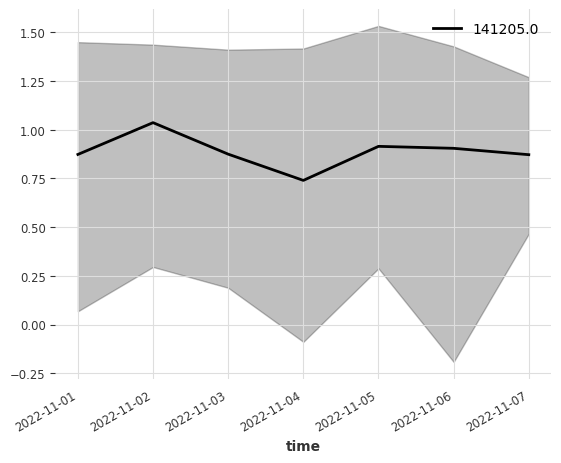

In [53]:
single_component.plot()

In [58]:
import matplotlib.pyplot as plt

def plot(predictions, series_clusters):
    if len(predictions) == 1:
        rows = len(predictions[0].components)
    else:
        rows = len(predictions)
    cols=1

    fig, axs = plt.subplots(rows, cols, figsize=(14, 6 * rows))
    idx = 0
    for forecast_cluster, series_cluster in zip(predictions, series_clusters):
        components = forecast_cluster.components
        for component, location_id in zip(components, components):
            forecast = forecast_cluster.univariate_component(component)
            actual = series_cluster.univariate_component(component)[forecast_cluster.time_index]

            forecast.plot(label="Forecast", ax=axs[idx])
            actual.plot(label="Actual", ax=axs[idx])
            axs[idx].set_title(f"Forecast Evaluation, location id: {location_id}")
            idx += 1

    return fig, axs

In [74]:
import matplotlib.pyplot as plt

def plot(predictions, series_clusters):
    idx = 0
    figs = {}
    for forecast_cluster, series_cluster in zip(predictions, series_clusters):
        components = forecast_cluster.components
        for component, location_id in zip(components, components):
            fig, axs = plt.subplots(1, 1, figsize=(14, 6))
            forecast = forecast_cluster.univariate_component(component)
            actual = series_cluster.univariate_component(component)[forecast_cluster.time_index]

            forecast.plot(label="Forecast", ax=axs)
            actual.plot(label="Actual", ax=axs)
            axs.set_title(f"Forecast Evaluation, location id: {location_id}")
            idx += 1
            figs[location_id] = fig 
    return figs

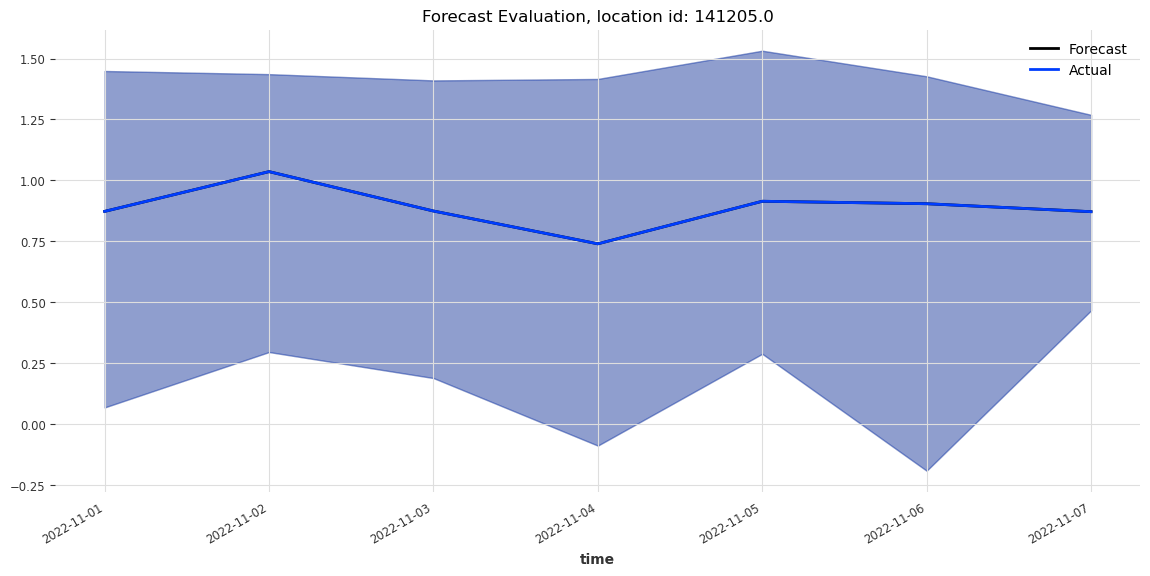

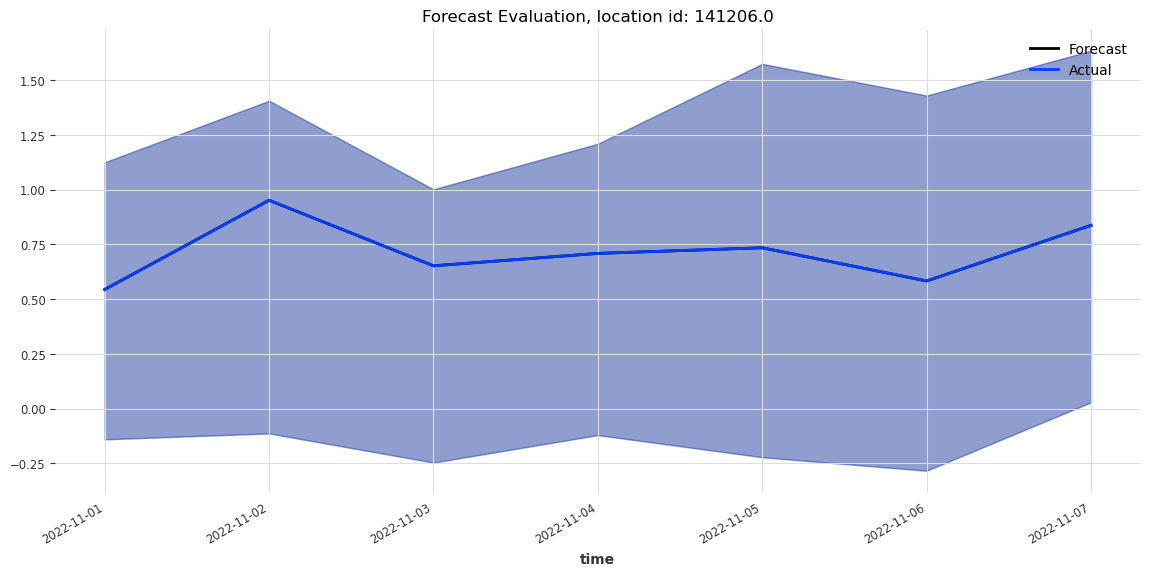

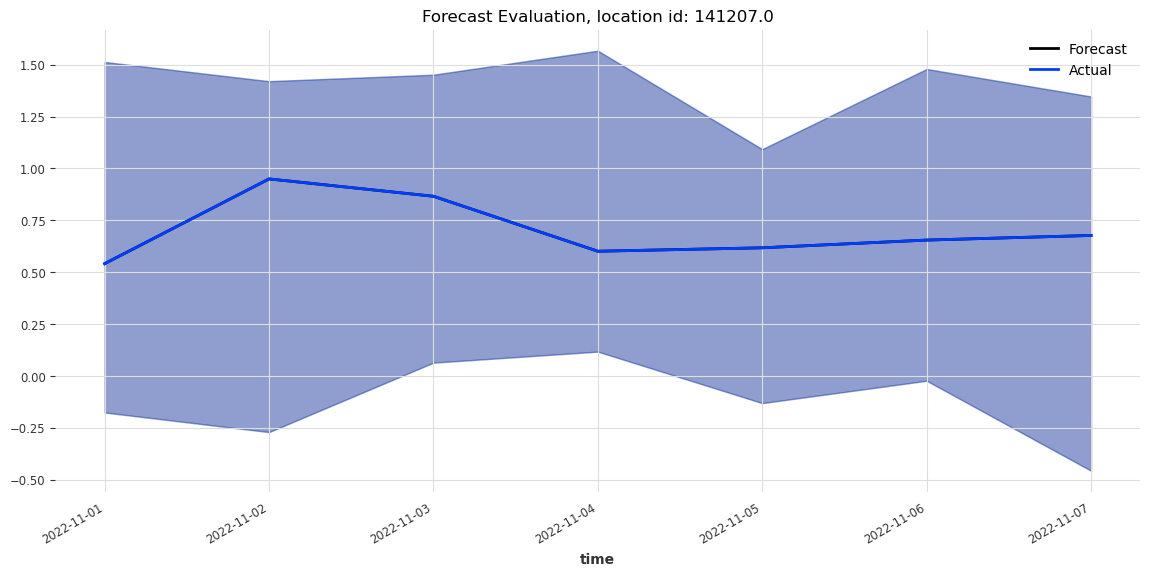

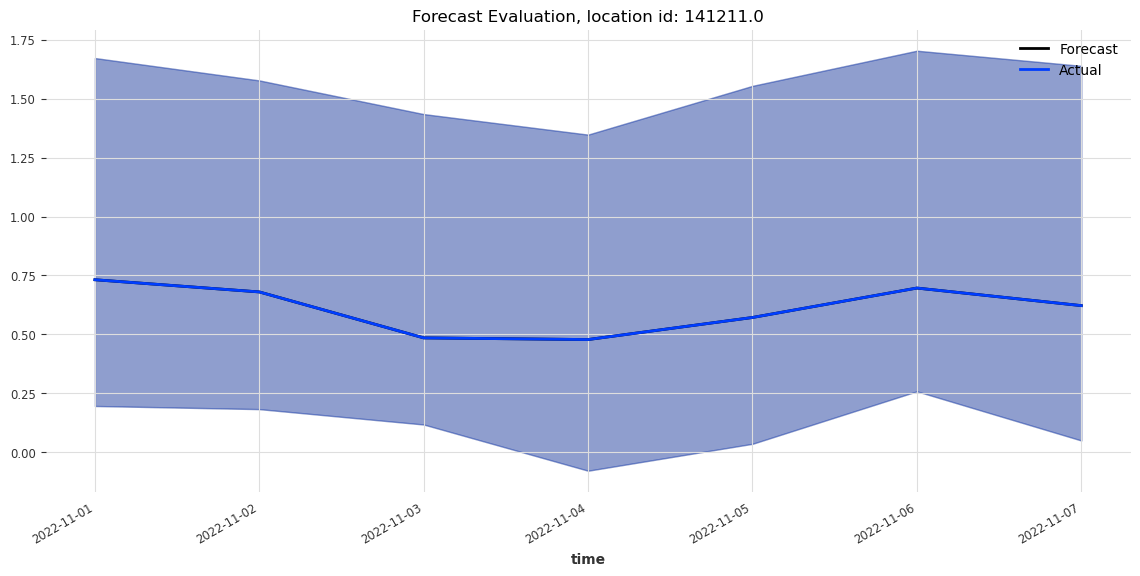

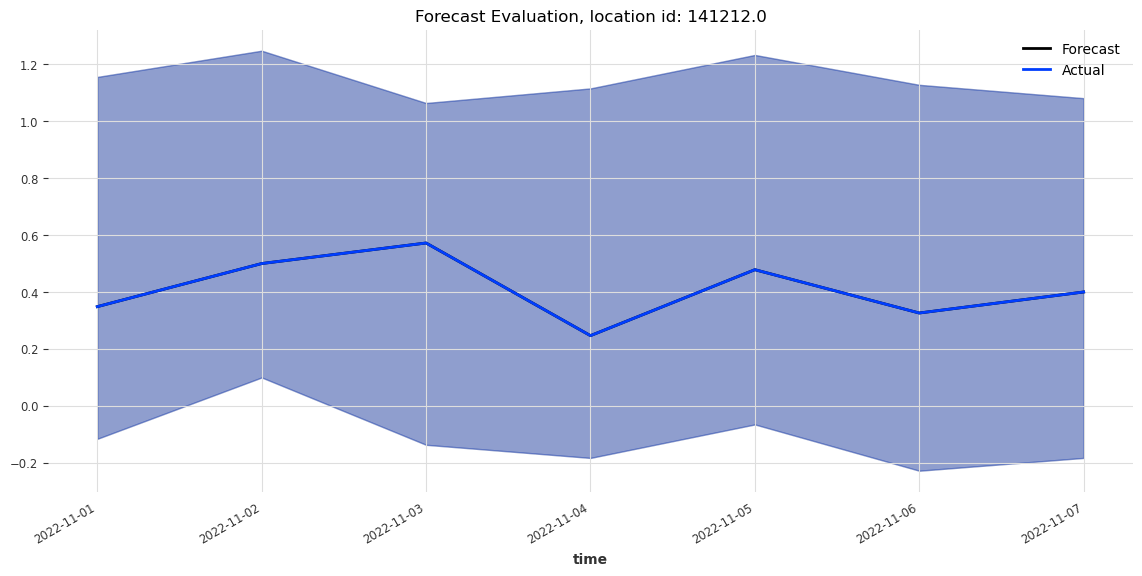

In [75]:
fig = plot([predictions], [predictions])

In [76]:
fig

{'141205.0': <Figure size 1400x600 with 1 Axes>,
 '141206.0': <Figure size 1400x600 with 1 Axes>,
 '141207.0': <Figure size 1400x600 with 1 Axes>,
 '141211.0': <Figure size 1400x600 with 1 Axes>,
 '141212.0': <Figure size 1400x600 with 1 Axes>}